# Check how good the binary masks are and how elliptical the cells are
We use the cdb ellipse and polygon data respectively to see how the area changes after conversion to the binary mask.

Furthermore, the shape of the polygon shape is evaluated and compared to an elliptical fit.

In [2]:
#!pip install clickpoints==1.9.3

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse # display only
from skimage.draw import ellipse       # generate binary mask
from PIL import Image
from cv2 import ellipse as cv2ellipse

In [3]:
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally

# Polygon data

In [94]:
import os
import imageio
import numpy as np
import clickpoints
from matplotlib.path import Path
from skimage.measure import label, regionprops

search_path = '../results/cell_contours/train'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))
print(file_list)

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

nx, ny = 540,720
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T

masks = []
areas = []
masks_tot = []

fn = []
tp = []
fp = []

for cdb_file in file_list:
    cdb = clickpoints.DataFile(cdb_file)
    cdb_path = os.path.split(cdb_file)[0]
    q_elli = cdb.getPolygons()
    print("#%d found" % q_elli.count())

    # get the image ids which contain at least on ellipse
    img_ids = np.unique([el.image.id for el in q_elli])

    for id in img_ids:

        # get image object by id and image data
        img_o = cdb.getImage(id=id)
        img   = img_o.get_data()
        # get ellipses in this image 
        q_elli_img = cdb.getPolygons(image=img_o)

        mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
        q_polys=cdb.getPolygons(image=img_o)
        area = 0
        for pol in q_polys:
            if np.shape(pol)[0] != 0:
                polygon = np.array([[pol.points]])
                path = Path(polygon.squeeze())
                grid = path.contains_points(points)
                grid = grid.reshape((ny,nx))
                mask = grid
                masks_tot.append(mask)

                area = PolyArea(pol.points[:,0],pol.points[:,1])
                if area == 0:
                    continue
                areas.append(area)
                masks.append(np.sum(mask))
                
                label_mask = label(mask)
                #for region in regionprops(label_mask): #region props are based on the original image
                mask_el = np.zeros((img.shape[0:2]), dtype=np.uint8)
                for el in regionprops(label_mask):
                    xs,ys = ellipse(el.centroid[0], el.centroid[1],  el.major_axis_length/2, el.minor_axis_length/2, rotation=el.orientation)
                    for i in range(len(xs)):
                        if xs[i] < 720 and ys[i]<540:
                            mask_el[xs[i],ys[i]] = 1
                    #a = region.major_axis_length
                    #b = region.minor_axis_length
                    #area_ellipse = np.pi * a * b / 4
                    
                fn.append(np.sum(mask) - np.sum(mask*mask_el)) #pixels inside the binary mask but not in the ellipse fit
                tp.append(np.sum(mask*mask_el)) #pixels inside both the ellipse and the binary mask
                fp.append(np.sum(np.sum(mask_el) - np.sum(mask*mask_el))) #pixels inside the ellipse but not the binary mask
        #mask_path = os.path.join(cdb_path.replace("/data/", "/results/raw_masks/"), img_o.path.path)
        #mask_file = os.path.abspath(os.path.join(mask_path, img_o.filename.replace(img_o.ext, ".tif")))
        #print(mask_file)
        #Image.fromarray(mask).save(mask_file, compression="tiff_adobe_deflate")
    
areas = np.array(areas)
masks = np.array(masks)  
fn = np.array(fn)
fp = np.array(fp)
tp = np.array(tp)

['/tf/results/cell_contours/train/gt_8_selina.cdb', '/tf/results/cell_contours/train/gt_7_selina.cdb', '/tf/results/cell_contours/train/gt_4_selina.cdb', '/tf/results/cell_contours/train/gt_5_richard.cdb', '/tf/results/cell_contours/train/gt_0_selina.cdb', '/tf/results/cell_contours/train/gt_3_selina.cdb', '/tf/results/cell_contours/train/gt_6_selina.cdb']
path /tf/results/cell_contours/train/gt_8_selina.cdb
Open database with version 22
#241 found
path /tf/results/cell_contours/train/gt_7_selina.cdb
Open database with version 22
#310 found
path /tf/results/cell_contours/train/gt_4_selina.cdb
Open database with version 22
#302 found
path /tf/results/cell_contours/train/gt_5_richard.cdb
Open database with version 22
#411 found
path /tf/results/cell_contours/train/gt_0_selina.cdb
Open database with version 22
#484 found
path /tf/results/cell_contours/train/gt_3_selina.cdb
Open database with version 22
#416 found
path /tf/results/cell_contours/train/gt_6_selina.cdb
Open database with vers

In [61]:
print(areas.shape,masks.shape,fn.shape, tp.shape,fp.shape)

(2447,) (2447,) (2447,) (2447,) (2447,)


0.07093221050455671
3.652643372333503
3.1601649046592694e-05
0.0029036557050372094


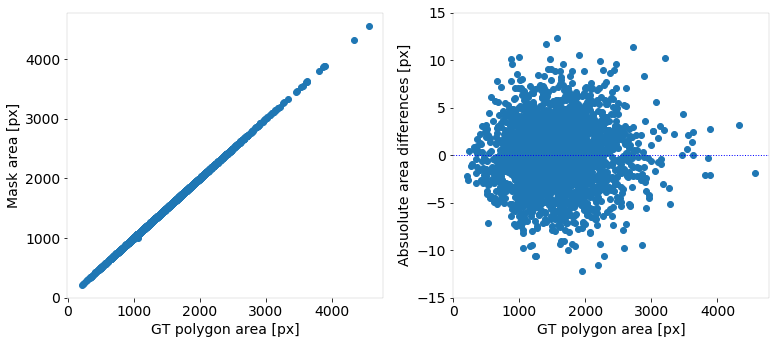

In [122]:
import matplotlib.pyplot as plt

#%%----------general fonts for plots and figures----------
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally


fig, axes = plt.subplots(1,2,figsize=[11,5],)
axes=np.array(axes) 

ax = axes[0]
ax.scatter(areas,masks)
ax.set_xlabel("GT polygon area [px]")
ax.set_ylabel("Mask area [px]")

ax = axes[1]
ax.scatter(areas,(areas - masks))
ax.set_xlabel("GT polygon area [px]")
ax.set_ylabel("Absuolute area differences [px]")

#ax = axes[2]
#line_props = dict(color="r", alpha=0.3)
#bbox_props = dict(color="g", alpha=0.9)
#flier_props = dict(marker="o", markersize=10)
#ax.set_ylim(-0.02,0.02)
ax.set_ylim(-15,15)
#plt.boxplot((areas - masks)/masks, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)

#ax.plot(1,np.mean(areas - masks))
#ax.set_xlabel("areas of the ellipses")
#ax.set_ylabel("Relative differences in the areas [px*px]")
plt.axhline(linewidth=1,color='b',linestyle=':')
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False)

fig.tight_layout()
#plt.savefig('/tf/results/results_new/' + 'binary_masks_polygons_2.png')

print(np.mean((areas-masks)))
print(np.std((areas-masks)))
print(np.mean((areas-masks)/masks))
print(np.std((areas-masks)/masks))

-1398.0


(1398.6438281701412, 1399, 1.0)

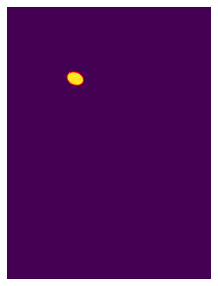

In [97]:
def fit_ellipses_regionprops(p):
    labeled = label(p)
    out = []
    for region in regionprops(labeled,p):  
        a = region.major_axis_length / 2
        b = region.minor_axis_length / 2
        r = np.sqrt(a * b)
        circum = np.pi * ((3 * (a + b)) - np.sqrt(10 * a * b + 3 * (a**2 + b**2)))
        if region.area >= 300: #analyze only regions larger than 100 pixels
        #if region.area >= Amin_pixels:
            fit = ((region.centroid[0],region.centroid[1]),(region.minor_axis_length,region.major_axis_length),90 - np.rad2deg(-region.orientation))
            out.append(fit)
    return out
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

i = 2341
fig, ax = plt.subplots(1,1,figsize=[4,5],)
plt.imshow(masks_tot[i])
for ell in fit_ellipses_regionprops(masks_tot[i].squeeze()):
    xy, (a,b), phi = ell
    e = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=False, edgecolor = 'red',linestyle='-' ,linewidth=1)
    ax.add_artist(e)
    e.set_alpha(1)
    e.set_facecolor((1.,0.,0.))
    #e.set_edgecolor(('r'))
plt.axis('off')
#plt.savefig('/tf/results/results_new/' + 'example_elliptical' + str(i) + '.png')
print(-(masks[i] - area_ellipse_fit[i]))
areas[i], masks[i], area_ellipse_fit[i]

## Test how elliptical are the polygon shapes
tp, fn, and fp were calculated adn precision, recall, and f1 score for all data points is evaluated.

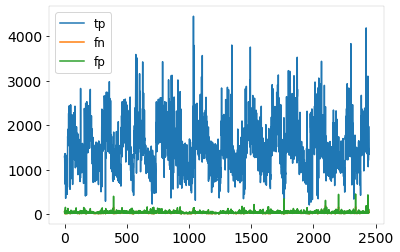

In [111]:
plt.plot(tp)
plt.plot(fn)
plt.plot(fp)
plt.legend(['tp','fn','fp'])

0.9774716799677844 0.01360399944185437
0.9794175703053947 0.010491415529996112
0.9755643276186361 0.016765490686392825


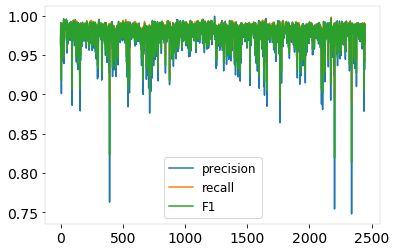

In [116]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

plt.plot(precision)
plt.plot(recall)
plt.plot(f1)
plt.legend(['precision','recall','F1'])
print(np.mean(f1),np.std(f1))
print(np.mean(recall),np.std(recall))
print(np.mean(precision),np.std(precision))

# Ellipse data

In [123]:
# MAIN PROCESSING LOOP

# TODO do we export all images or just hte ones with ellipsoids? might be good as negative samples?
import clickpoints
import cv2

search_path = '../data/ml1_raw'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith("ML.cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))

masks = []
areas = []
area_ellipse_fit = []
for cdb_file in file_list:
    cdb = clickpoints.DataFile(cdb_file)
    cdb_path = os.path.split(cdb_file)[0]
    q_elli = cdb.getEllipses()
    print("#%d found" % q_elli.count())

    # get the image ids which contain at least on ellipse
    img_ids = np.unique([el.image.id for el in q_elli])

    for id in img_ids:

        # get image object by id and image data
        img_o = cdb.getImage(id=id)
        img   = img_o.get_data()
        # get ellipses in this image 
        q_elli_img = cdb.getEllipses(image=img_o)

        mask = np.zeros((img.shape[0:2]), dtype=np.uint8)

        area = 0
        for el in q_elli_img:
            #print(el.angle)
            xs,ys = ellipse(el.x, el.y,  el.width/2, el.height/2, rotation=np.deg2rad(el.angle))
            mask[ys,xs] = 1
            
            #area_ellipse_fit
            area += np.pi * el.height * el.width / 4
            areas.append(area)
            masks.append(np.sum(mask))
        #mask_path = os.path.join(cdb_path.replace("/data/", "/results/raw_masks/"), img_o.path.path)
        #mask_file = os.path.abspath(os.path.join(mask_path, img_o.filename.replace(img_o.ext, ".tif")))
        #print(mask_file)
        #Image.fromarray(mask).save(mask_file, compression="tiff_adobe_deflate")
    
areas = np.array(areas)
masks = np.array(masks)

path /tf/data/ml1_raw/ML_p3/ellipsoide_ML.cdb
Open database with version 22
#75 found
path /tf/data/ml1_raw/ML_p2/ellipsoide_ML.cdb
Open database with version 22
#71 found
path /tf/data/ml1_raw/ML_p1/ellipsoide_ML.cdb
Open database with version 22
#136 found


#136 found
32.75744926743544
855
852.041094018728


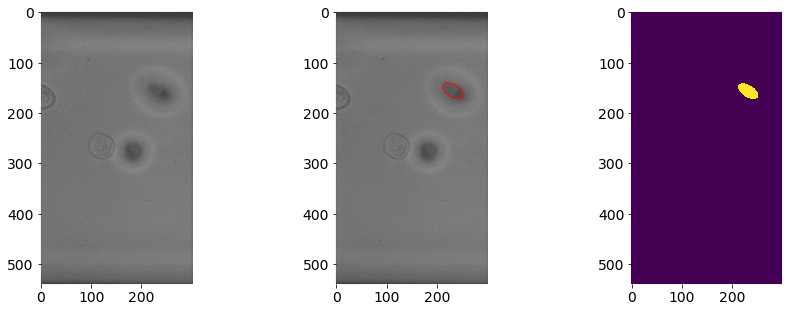

In [124]:
# KEEP this code segment for demonstration and debugging
# TODO do we export all images or just the ones with ellipsoids? might be good as negative samples?

q_elli = cdb.getEllipses()
print("#%d found" % q_elli.count())

# get the image ids which contain at least on ellipse
img_ids = np.unique([el.image.id for el in q_elli])

#for id in img_ids:
id = img_ids[10]   #11 with 2 
    
# get image object by id and image data
img_o = cdb.getImage(id=id)
img   = img_o.get_data()
# get ellipses in this image 
q_elli_img = cdb.getEllipses(image=img_o)


plt.figure(figsize=[15,5])
# show image
ax = plt.subplot(1,3,1)
plt.imshow(img)

# debug show coordinates
ax = plt.subplot(1,3,2)
plt.imshow(img)
area = 0
for el in q_elli_img:
    #print(el)
    draw_el = Ellipse([el.x, el.y], el.width, el.height, el.angle, fill=False, edgecolor='red')
    ax.add_patch(draw_el)
    area += np.pi * el.height * el.width / 4
# show calculated binary mask
ax = plt.subplot(1,3,3)

mask = np.zeros((img.shape[0:2]), dtype=np.uint8)

for el in q_elli_img:
    print(el.angle)
    xs,ys = ellipse(el.x, el.y,  el.width/2, el.height/2, rotation=np.deg2rad(el.angle))
    mask[ys,xs] = 1

plt.imshow(mask)
    
print(np.sum(mask))
print(area)
#break



0.0039040143955174516
3.65505372974084
4.6042973771153045e-05
0.0016195321218951289
12.306507894146762


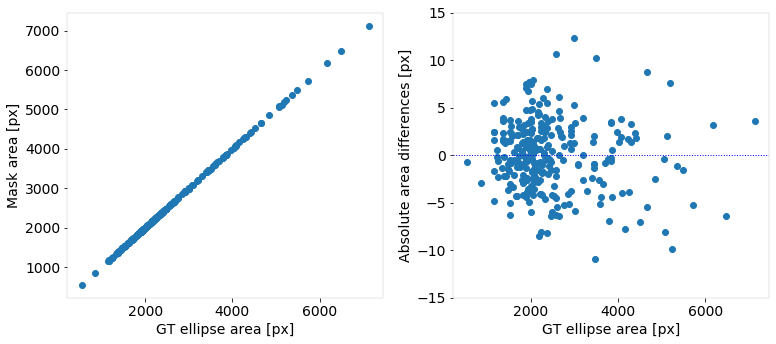

In [125]:
import matplotlib.pyplot as plt

#%%----------general fonts for plots and figures----------
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally


fig, axes = plt.subplots(1,2,figsize=[11,5],)
axes=np.array(axes) 

ax = axes[0]
ax.scatter(areas,masks)
ax.set_xlabel("GT ellipse area [px]")
ax.set_ylabel("Mask area [px]")

ax = axes[1]
ax.scatter(areas,(areas - masks))
ax.set_xlabel("GT ellipse area [px]")
ax.set_ylabel("Absolute area differences [px]")

#ax = axes[2]
#line_props = dict(color="r", alpha=0.3)
#bbox_props = dict(color="g", alpha=0.9)
#flier_props = dict(marker="o", markersize=10)
#ax.set_ylim(-0.02,0.02)
ax.set_ylim(-15,15)
#plt.boxplot((areas - masks)/masks, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)

#ax.plot(1,np.mean(areas - masks))
#ax.set_xlabel("areas of the ellipses")
#ax.set_ylabel("Relative differences in the areas [px*px]")
plt.axhline(linewidth=1,color='b',linestyle=':')
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False)

fig.tight_layout()
#plt.savefig('/tf/results/results_new/' + 'binary_masks_ellipse_abs.png')

print(np.mean((areas-masks)))
print(np.std((areas-masks)))
print(np.mean((areas-masks)/masks))
print(np.std((areas-masks)/masks))
print(np.max(areas-masks))